In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0067.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0153.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0105.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0018.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0050.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0029.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0195.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0051.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0074.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0142.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0149.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0121.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0194.png
/kaggle/input/leapgestrecog/leapGestRecog/07/02_l/frame_07_02_0003.png
/kaggl


**Step 1: Import Necessary Libraries**
We start by importing essential libraries for data manipulation, visualization, and model building

In [2]:
# Libraries for data handling and visualization
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for image preprocessing and machine learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# For splitting data
from sklearn.model_selection import train_test_split


**Step 2: Load and Explore the Dataset**
Verify the dataset structure.
Visualize a few images to understand the gesture variations.

Total Images Found: 20000
Gesture Classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']


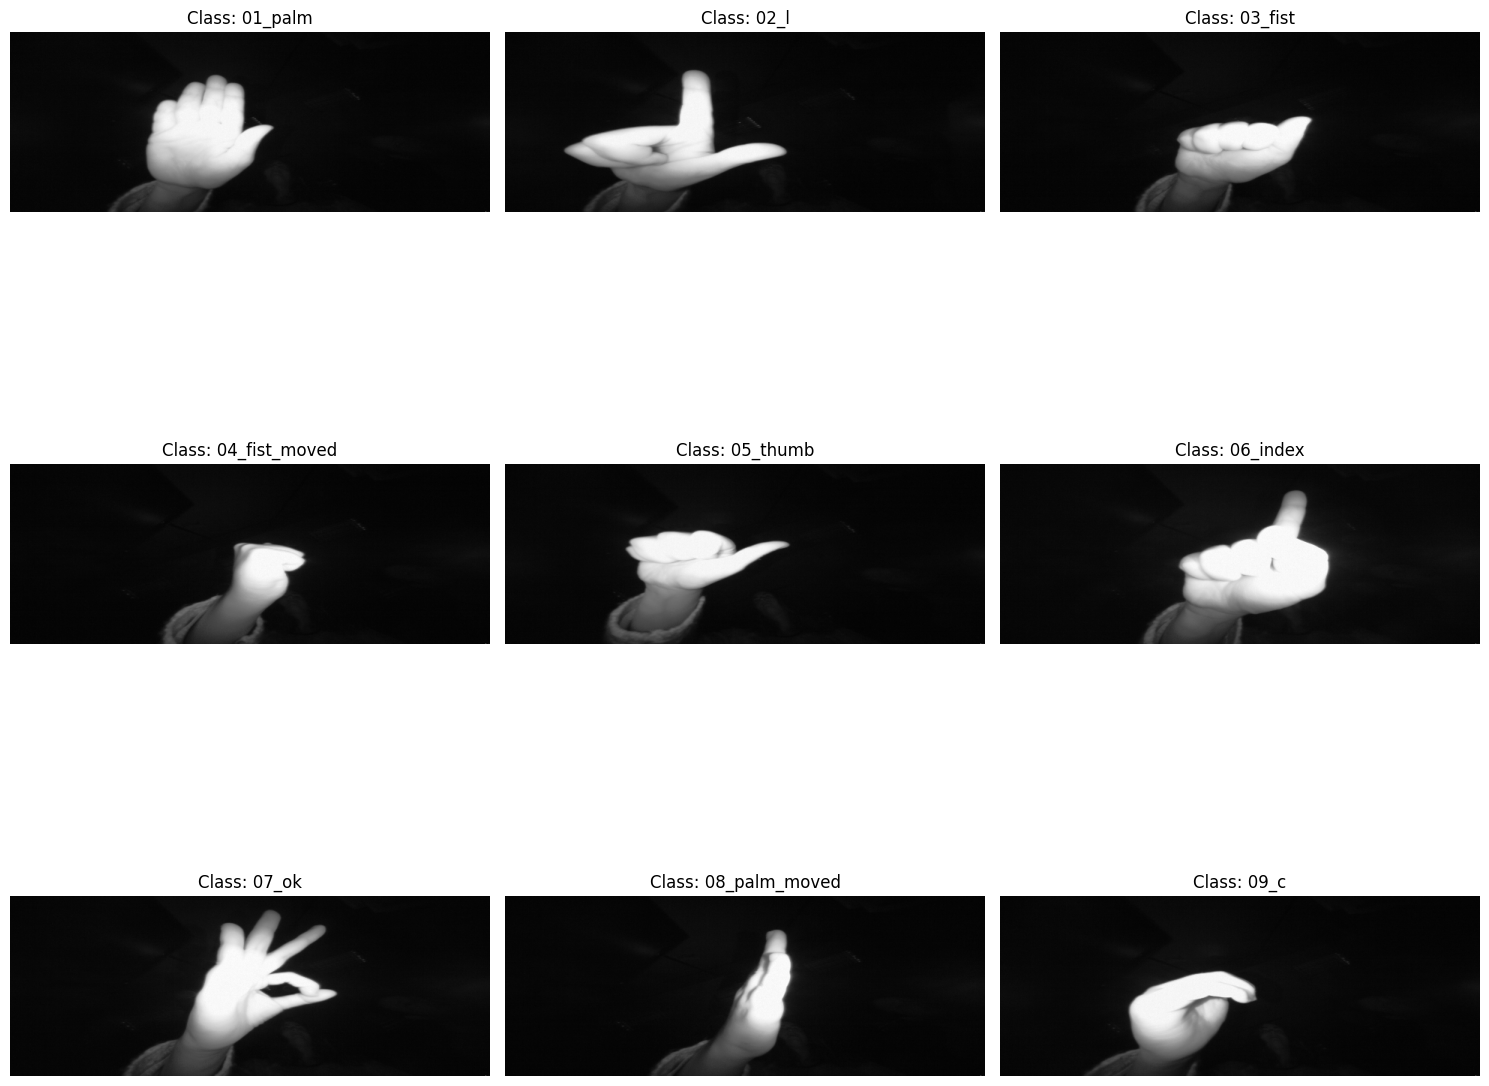

In [18]:
import glob
import cv2
import os
import matplotlib.pyplot as plt

# Set the dataset path and retrieve all image paths
dataset_path = '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/*/*/*.png'
image_paths = glob.glob(dataset_path)
print(f"Total Images Found: {len(image_paths)}")

# Organize image paths by class for easier loading
class_labels = sorted({os.path.basename(os.path.dirname(img_path)) for img_path in image_paths})
print(f"Gesture Classes: {class_labels}")

# Create a dictionary to hold paths by class
class_images = {label: [] for label in class_labels}
for img_path in image_paths:
    class_name = os.path.basename(os.path.dirname(img_path))
    class_images[class_name].append(img_path)

# Display a few sample images per class
plt.figure(figsize=(15, 15))
for i, label in enumerate(class_labels[:9]):
    img_path = class_images[label][0]  # Get the first image of each class
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for display
    
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()


**Step 3: Preprocess the Images**
Resize images for input to CNN.
Normalize pixel values.
Split the data into training, validation, and test sets.

In [19]:
import tensorflow as tf

# Set image dimensions and batch size
img_width, img_height = 64, 64
batch_size = 16  # Reduced batch size

# Load the dataset with a 80-20 train-validation split
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training"
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog',
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_width, img_height),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation"
)

# Display class indices
class_names = train_dataset.class_names
print("Class Indices:", class_names)


Found 20000 files belonging to 10 classes.
Using 16000 files for training.
Found 20000 files belonging to 10 classes.
Using 4000 files for validation.
Class Indices: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [30]:
# Determine the number of classes
num_classes = len(train_dataset.class_names)

# Initialize a CNN model
model = Sequential()

# Add Convolutional layers with pooling and dropout
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten and fully connect
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')  # Use .keras extension

# Train the model
epochs = 30
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint]
)



Epoch 1/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 98s 96ms/step - accuracy: 0.2492 - loss: 4.2668 - val_accuracy: 0.8723 - val_loss: 0.4718
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.7290 - loss: 0.7482 - val_accuracy: 0.9815 - val_loss: 0.0679
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 141s 85ms/step - accuracy: 0.8806 - loss: 0.3304 - val_accuracy: 0.9815 - val_loss: 0.0338
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.9288 - loss: 0.1912 - val_accuracy: 0.9862 - val_loss: 0.0308
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9461 - loss: 0.1467 - val_accuracy: 0.9877 - val_loss: 0.0177
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9649 - loss: 0.1039 - val_accuracy: 0.9885 - val_loss: 0.0188
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.9694 - loss: 0.0944 - val_accuracy: 0.9890 - val_loss: 0.0179
Epoch 8/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 142s 85ms/step - accuracy: 0.9719

In [34]:
# Load the best model
model.load_weights('best_model.keras')  

# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.9939 - loss: 0.0116
Validation Accuracy: 0.99, Validation Loss: 0.01


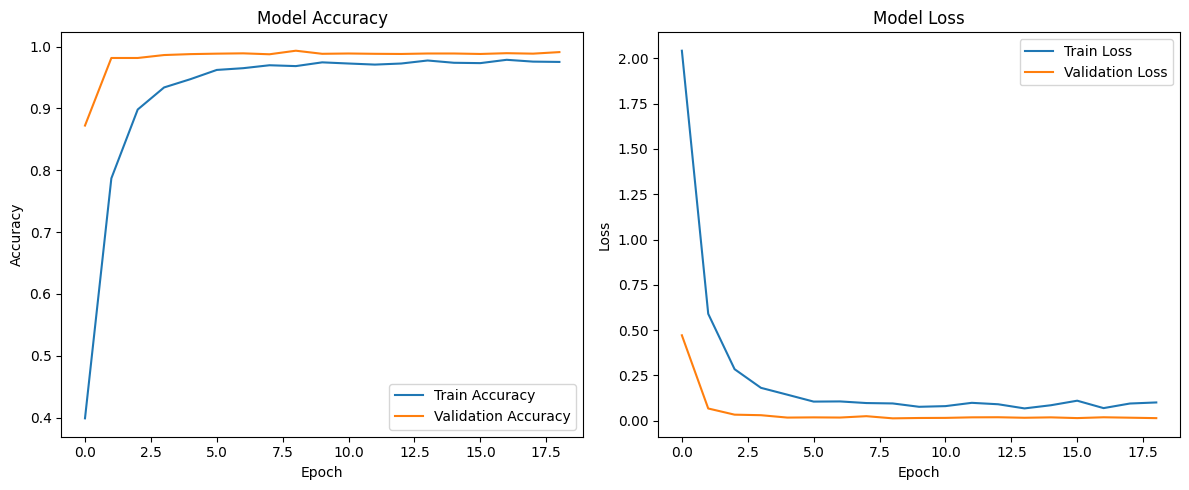

In [35]:
# Plot accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Gesture: 01


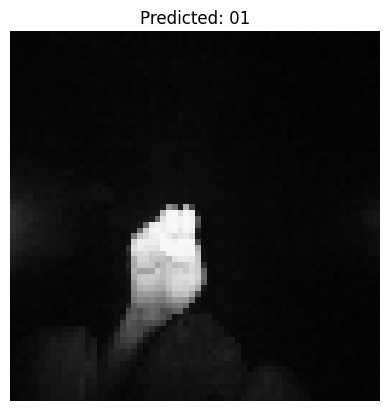

In [38]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Update the predict_gesture function
def predict_gesture(img_path, model):
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img) / 255.0  # Normalize the image
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Prediction
    prediction = model.predict(img_array)
    class_idx = np.argmax(prediction)
    class_name = train_dataset.class_names[class_idx]  # Accessing class names from the dataset

    print(f"Predicted Gesture: {class_name}")
    plt.imshow(img)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

# Example usage
predict_gesture('/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/01/03_fist/frame_01_03_0045.png', model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/02/04_hand_open/frame_02_04_0010.png'

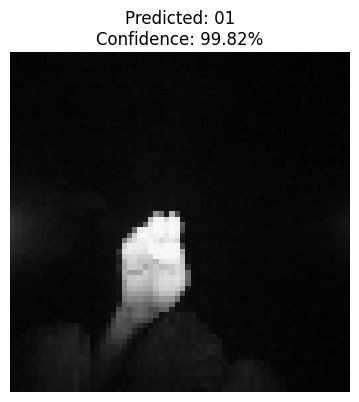

In [40]:
def plot_predictions(image_paths, model):
    plt.figure(figsize=(15, 15))
    
    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Prediction
        prediction = model.predict(img_array)
        class_idx = np.argmax(prediction)
        class_name = train_dataset.class_names[class_idx]
        confidence = np.max(prediction) * 100  # Get confidence percentage

        # Plot
        plt.subplot(3, 3, i + 1)  # Change the number of rows/columns as needed
        plt.imshow(img)
        plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2f}%")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
image_paths = [
    '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/01/03_fist/frame_01_03_0045.png',
    '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/02/04_hand_open/frame_02_04_0010.png',
    '/kaggle/input/leapgestrecog/leapgestrecog/leapGestRecog/03/02_finger_up/frame_03_02_0005.png',
    # Add more image paths as needed
]

plot_predictions(image_paths, model)


